In [2]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import sys
import os

In [3]:
data_dir = 'data/middleburry/artroom1'

In [5]:
image_left_path = os.path.join(data_dir, 'im0.png')
image_right_path = os.path.join(data_dir, 'im1.png')
calib_file_path = os.path.join(data_dir, 'calib.txt')

In [ ]:
left_rectified = cv2.imread(image_left_path)
right_rectified = cv2.imread(image_right_path)

In [39]:
calib = {}

with open(calib_file_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        key, value = line.split('=')
        calib[key] = value
        if 'cam' in key:
            rows = calib[key].strip('[]\n').split(';')
            data = [float(num) for row in rows for num in row.strip().split()]
            matrix = np.array(data).reshape(3, 3)
            calib[key] = matrix
        else:
            calib[key] = float(calib[key])

    f.close()

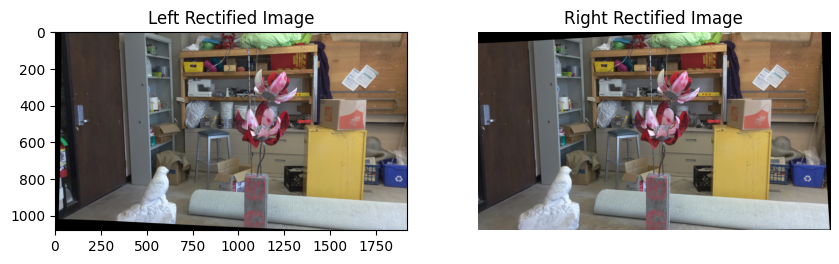

In [10]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Left Rectified Image')
plt.imshow(cv2.cvtColor(left_rectified, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title('Right Rectified Image')
plt.imshow(cv2.cvtColor(right_rectified, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

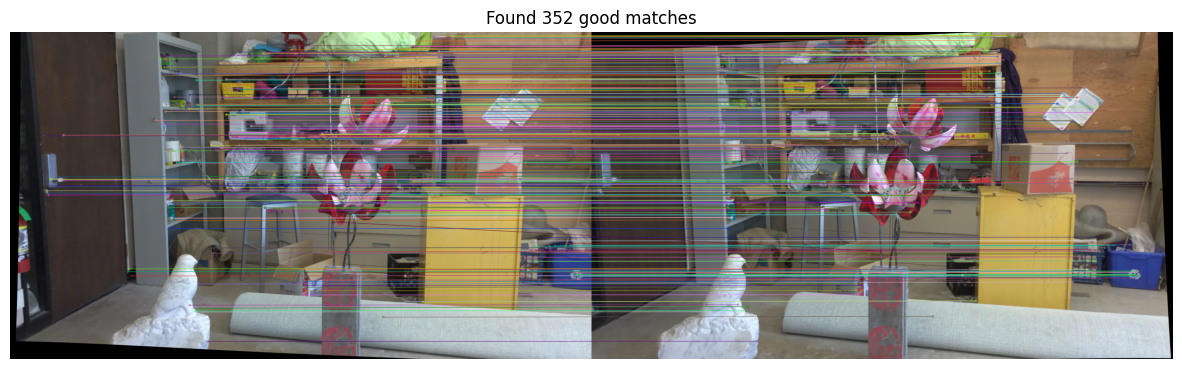

In [11]:
def find_and_visualize_matches(left_rectified, right_rectified, nfeatures=100, max_points=50):
    # Convert to grayscale
    gray_left = cv2.cvtColor(left_rectified, cv2.COLOR_BGR2GRAY)
    gray_right = cv2.cvtColor(right_rectified, cv2.COLOR_BGR2GRAY)

    # Initialize SIFT detector with reduced features
    sift = cv2.SIFT_create(nfeatures=nfeatures)  # Reduce number of features

    # Find keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(gray_left, None)
    kp2, des2 = sift.detectAndCompute(gray_right, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    # FLANN matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # Filter good matches using stricter Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.6 * n.distance:  # Stricter ratio
            good_matches.append(m)

    # Sort matches by distance and take top N
    good_matches = sorted(good_matches, key=lambda x: x.distance)
    good_matches = good_matches[:max_points]

    # Draw matches
    matched_img = cv2.drawMatches(
        left_rectified, kp1,
        right_rectified, kp2,
        good_matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    # Visualize
    plt.figure(figsize=(15, 5))
    plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
    plt.title(f'Found {len(good_matches)} good matches')
    plt.axis('off')
    plt.show()

    return kp1, kp2, good_matches

# Call with reduced number of points
kp1, kp2, good_matches = find_and_visualize_matches(left_rectified, right_rectified, 
                                                    max_points=1000, nfeatures=1000)

# Disparity map

In [61]:
left_rectified_gray = cv2.cvtColor(left_rectified, cv2.COLOR_BGR2GRAY)
right_rectified_gray = cv2.cvtColor(right_rectified, cv2.COLOR_BGR2GRAY)

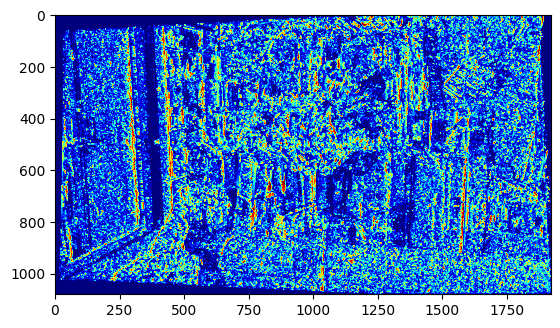

In [62]:
stereo = cv2.StereoBM.create(numDisparities=16*1, blockSize=5)
disparity = stereo.compute(left_rectified_gray, right_rectified_gray, cv2.CV_32F)
plt.imshow(disparity, cmap='jet')
plt.show()

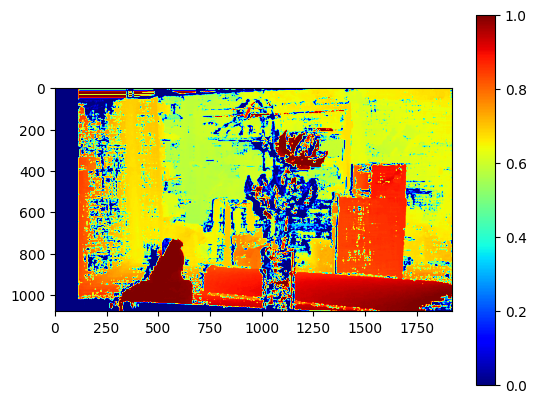

In [80]:
stereo = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=16*7,  # Must be divisible by 16
    blockSize=7,
    P1=8 * 3 * 7 ** 2,
    P2=32 * 3 * 7 ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=50,
    speckleRange=32,
    preFilterCap=63,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)

# Tính disparity map từ ảnh đã làm phẳng
disparity = stereo.compute(left_rectified, right_rectified).astype(np.float32) / 16.0
plt.imshow((disparity - disparity.min()) / (disparity.max() - disparity.min()), cmap='jet')
plt.colorbar()
plt.show()

# Depth map

In [45]:
calib

{'cam0': array([[1.73374e+03, 0.00000e+00, 7.92270e+02],
        [0.00000e+00, 1.73374e+03, 5.41890e+02],
        [0.00000e+00, 0.00000e+00, 1.00000e+00]]),
 'cam1': array([[1.73374e+03, 0.00000e+00, 7.92270e+02],
        [0.00000e+00, 1.73374e+03, 5.41890e+02],
        [0.00000e+00, 0.00000e+00, 1.00000e+00]]),
 'doffs': 0.0,
 'baseline': 536.62,
 'width': 1920.0,
 'height': 1080.0,
 'ndisp': 170.0,
 'vmin': 55.0,
 'vmax': 142.0}

In [43]:
baseline = calib['baseline']
print('Baseline:', baseline)

Baseline: 536.62


In [74]:
focal_length = (calib['cam0'][0][0] + calib['cam1'][1][1]) / 200
print('Focal Length:', focal_length)

Focal Length: 17.3374


In [77]:
# Calculate the depth map
depth_map = np.zeros(disparity.shape, dtype=np.float32)
depth_map[disparity > 0] = (focal_length * baseline) / disparity[disparity > 0 ]

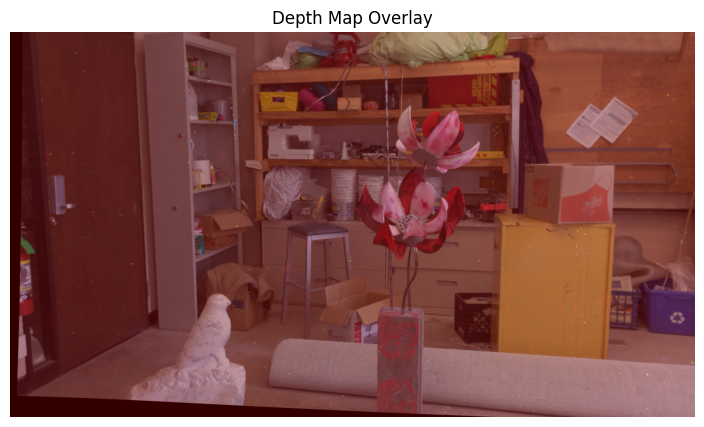

In [78]:
# Normalize the depth map for visualization
depth_map_normalized = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)

# Convert the normalized depth map to an 8-bit image
depth_map_normalized = np.uint8(depth_map_normalized)

# Apply a color map to the normalized depth map
depth_map_colored = cv2.applyColorMap(depth_map_normalized, cv2.COLORMAP_JET)

# Overlay the depth map on the original image
overlay = cv2.addWeighted(cv2.cvtColor(left_rectified, cv2.COLOR_BGR2RGB), 0.6, depth_map_colored, 0.4, 0)

# Display the result
plt.figure(figsize=(10, 5))
plt.title('Depth Map Overlay')
plt.imshow(overlay)
plt.axis('off')
plt.show()

# Visualize

In [75]:
def nothing(x):
    pass

cv2.namedWindow("Depth Map",cv2.WINDOW_NORMAL)
cv2.resizeWindow("Depth Map",600,600)
 
cv2.createTrackbar('numDisparities',"Depth Map",1,17,nothing)
cv2.createTrackbar('blockSize',"Depth Map",5,50,nothing)
cv2.createTrackbar('preFilterType',"Depth Map",1,1,nothing)
cv2.createTrackbar('preFilterSize',"Depth Map",2,25,nothing)
cv2.createTrackbar('preFilterCap',"Depth Map",5,62,nothing)
cv2.createTrackbar('textureThreshold',"Depth Map",10,100,nothing)
cv2.createTrackbar('uniquenessRatio',"Depth Map",15,100,nothing)
cv2.createTrackbar('speckleRange',"Depth Map",0,100,nothing)
cv2.createTrackbar('speckleWindowSize',"Depth Map",3,25,nothing)
cv2.createTrackbar('disp12MaxDiff',"Depth Map",5,25,nothing)
cv2.createTrackbar('minDisparity',"Depth Map",5,25,nothing)

stereo = cv2.StereoBM_create()

# Global variables to store cursor position
cursor_x, cursor_y = 0, 0


def mouse_callback(event, x, y, flags, param):
    global cursor_x, cursor_y
    if event == cv2.EVENT_MOUSEMOVE:
        cursor_x, cursor_y = x, y

cv2.setMouseCallback('Depth Map', mouse_callback)

while True:

    # Updating the parameters based on the trackbar positions
    numDisparities = cv2.getTrackbarPos('numDisparities',"Depth Map")*16
    blockSize = cv2.getTrackbarPos('blockSize',"Depth Map")*2 + 5
    preFilterType = cv2.getTrackbarPos('preFilterType',"Depth Map")
    preFilterSize = cv2.getTrackbarPos('preFilterSize',"Depth Map")*2 + 5
    preFilterCap = cv2.getTrackbarPos('preFilterCap',"Depth Map")
    textureThreshold = cv2.getTrackbarPos('textureThreshold',"Depth Map")
    uniquenessRatio = cv2.getTrackbarPos('uniquenessRatio',"Depth Map")
    speckleRange = cv2.getTrackbarPos('speckleRange',"Depth Map")
    speckleWindowSize = cv2.getTrackbarPos('speckleWindowSize',"Depth Map")*2
    disp12MaxDiff = cv2.getTrackbarPos('disp12MaxDiff',"Depth Map")
    minDisparity = cv2.getTrackbarPos('minDisparity',"Depth Map")

    # Setting the updated parameters before computing disparity map
    stereo.setNumDisparities(numDisparities)
    stereo.setBlockSize(blockSize)
    stereo.setPreFilterType(preFilterType)
    stereo.setPreFilterSize(preFilterSize)
    stereo.setPreFilterCap(preFilterCap)
    stereo.setTextureThreshold(textureThreshold)
    stereo.setUniquenessRatio(uniquenessRatio)
    stereo.setSpeckleRange(speckleRange)
    stereo.setSpeckleWindowSize(speckleWindowSize)
    stereo.setDisp12MaxDiff(disp12MaxDiff)
    stereo.setMinDisparity(minDisparity)
    
    # Calculating disparity using the StereoBM algorithm
    try:
        disparity = stereo.compute(left_rectified_gray, right_rectified_gray)
    except:
        break
    # NOTE: Code returns a 16bit signed single channel image,
    # CV_16S containing a disparity map scaled by 16. Hence it 
    # is essential to convert it to CV_32F and scale it down 16 times.
    
    # Converting to float32 
    disparity = disparity.astype(np.float32)
    
    # Scaling down the disparity values and normalizing them 
    disparity = (disparity/16.0 - minDisparity)/numDisparities
    
    # Displaying the disparity map
    # cv2.imshow("disp",disparity)

    depth_map = np.zeros(disparity.shape, dtype=np.float32)
    depth_map[disparity > 0] = (focal_length * focal_length) / disparity[disparity > 0]

    # Hiển thị depth map
    depth_map_normalized = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)
    depth_map_normalized = np.uint8(depth_map_normalized)
    depth_map_colored = cv2.applyColorMap(depth_map_normalized, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(cv2.cvtColor(left_rectified, cv2.COLOR_BGR2RGB), 0.6, depth_map_colored, 0.4, 0)
    # cv2.imshow("Depth Map Overlay", overlay)
    cv2.imshow("Depth Map", overlay)

    if cursor_x > 0 and cursor_y > 0:
        depth_value = depth_map[cursor_y, cursor_x]
        print(f'\033[K Depth at ({cursor_x}, {cursor_y}): {depth_value}', end='\r', flush=True)
    
    
    # Close window using esc key
    if cv2.waitKey(1) == 27:
        break
cv2.destroyAllWindows()

IndexError: index 1087 is out of bounds for axis 0 with size 1080